# COVID-19 Prediction using Transfer Learning

I'll be using transfer learning on a pre-trained CNN to build an COVID-19/Normal classifier!

<img src="TransferLearning.png" style="width:700px;height:300px;">

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently.

## Table of Content

- [1 - Import Packages](#5)
- [2 - Data Preprocess and Augmentation](#2)
    - [2.1 - Data Augmentation](#ex-1)
        - [Rescale Pixel Values](#)
    - [2.2 Create the Dataset in Training and Validation Sets](#3-3)
- [3 - Creating the base model from the pre-trained Convnets](#3-3)
    - [3.1 - Inside a Transfer Learning  Building Block](#3-3)
    - [3.2 - Layer Freezing with the Functional API](#)
- [4 - Compile the model](#3-3)
    - [4.1 - Train the model](#3-3)
    - [4.2 - Learning Curve](#ex-3)
- [5 - Confusion Matrix](#)
    - [5.1 - AUC & ROC Curve](#3-3)

<font color='blue'>
    
## 1. Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Model
from keras.models import Sequential
from keras.models import load_model

from keras.preprocessing import image
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score


<font color='blue'>

## 2. Data Preprocess and Augmentation

### 2.1 Data Augmentation

To increase diversity in the training set and help our model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. 

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit). More details about data augmentation in this [tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).

Official documents for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

#### Rescale Pixel Values

In a moment, we will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in our images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode="nearest",
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rotation_range=20,
                                   horizontal_flip = True)

In [3]:
validation_datagen = ImageDataGenerator(rescale = 1./255)

### 2.2 Create the Dataset in Training and Validation Sets

When training and evaluating deep learning models in Keras, generating a dataset from image files stored on disk is simple and fast. Call `flow_from_directory()` to read from the directory and create both training and validation datasets. 

In [4]:
INIT_LR = 1e-3
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
directory = "Dataset/"

In [5]:
# Train Datasets
training_set = train_datagen.flow_from_directory('Dataset/Train',
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 11046 images belonging to 2 classes.


In [6]:
class_names = training_set.class_indices
print(class_names)

{'Covid': 0, 'Normal': 1}


In [7]:
# Validation Datasets
validation_set = validation_datagen.flow_from_directory('Dataset/Validation',
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 2762 images belonging to 2 classes.


In [8]:
class_names = validation_set.class_indices
print(class_names)

{'Covid': 0, 'Normal': 1}


Now let's take a look at some of the Augumented images from the training set.

    First nine images and labels from the training set:

C:\Users\bhart\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\bhart\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


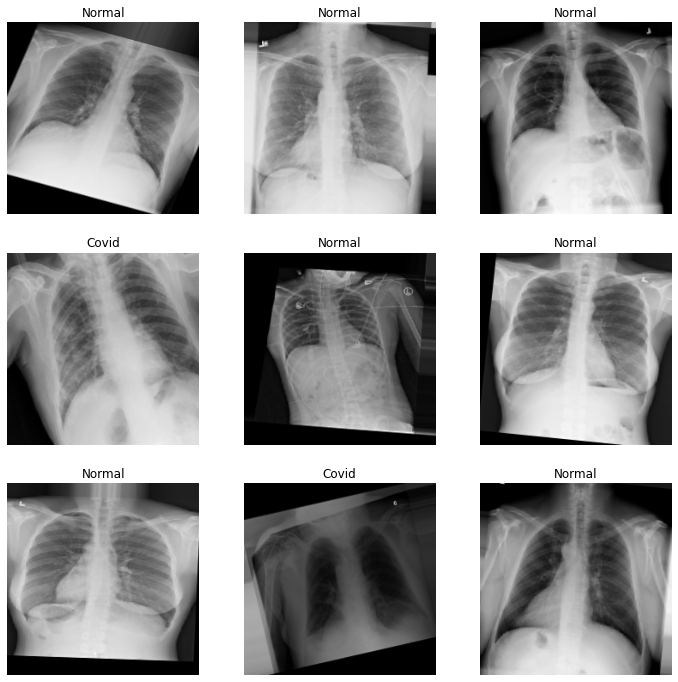

In [9]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img, label = training_set.next()
    plt.imshow(img[0], cmap='gray')
    dic = {0:'Covid', 1:'Normal'}
    plt.title(dic.get(np.where(label[0]==1)[0][0]))
    plt.axis('off')
plt.show()

<font color='blue'>

## 3. Creating the base model from the pre-trained Convnets

### 3.1 - Inside a ResNet50 Convolutional Building Block

<img src="ResNet.ppm" style="width:700px;height:400px;">

ResNet50 is a variant of ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer

### 3.2 Layer Freezing with the Functional API

We will see how we can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. We can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [10]:
# add preprocessing layer to the front of mobile_net
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')

In [11]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)

In [12]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

In [13]:
# # don't train existing weights
# for layer in base_model.layers:
#   layer.trainable = False

In [14]:
# # useful for getting number of classes
# folders = glob('/content/drive/MyDrive/Dataset/Train/*')

In [15]:
# # our layers - you can add more if you want
# x = Flatten()(base_model.output)
# # x = Dense(1000, activation='softmax')(x)
# prediction = Dense(len(folders), activation='softmax')(x)

In [16]:
# # create a model object
# model = Model(inputs=base_model.input, outputs=prediction)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
nb_layers = len(model.layers)
print(nb_layers)

180


In [15]:
print(base_model.layers[nb_layers - 8].name)
print(base_model.layers[nb_layers - 7].name)

conv5_block3_3_bn
conv5_block3_add


#### Not Important just for validation of our model

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [16]:
image_batch, label_batch = next(iter(training_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

C:\Users\bhart\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\bhart\Anaconda\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


(32, 7, 7, 2048)


In [17]:
# Not so Important just for validation of our model
#Shows the different label probabilities in one tensor 
label_batch

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.


<font color='blue'>

## 4. Compile the Model

In [18]:
# tell the model what cost and optimization method to use
EPOCHS = 10
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

C:\Users\bhart\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:
len(model.trainable_variables)

4

### 4.1 Train the Model

In [20]:
# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs

early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4, restore_best_weights=True)

In [21]:
# fit the model
# initial_epochs = 10
history = model.fit_generator(training_set,
                        validation_data=validation_set,
                        epochs=EPOCHS,
                        steps_per_epoch=len(training_set),
                        validation_steps=len(validation_set),
                        callbacks = [early_stopper])

<ipython-input-21-5dfe386d04a5>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_set,


Epoch 1/10
346/346 [==============================] - 1540s 4s/step - loss: 0.5847 - accuracy: 0.7346 - val_loss: 0.5610 - val_accuracy: 0.7382
Epoch 2/10
346/346 [==============================] - 1534s 4s/step - loss: 0.5667 - accuracy: 0.7374 - val_loss: 0.5475 - val_accuracy: 0.7382
Epoch 3/10
346/346 [==============================] - 1535s 4s/step - loss: 0.5505 - accuracy: 0.7381 - val_loss: 0.5316 - val_accuracy: 0.7382
Epoch 4/10
346/346 [==============================] - 1587s 5s/step - loss: 0.5403 - accuracy: 0.7378 - val_loss: 0.5329 - val_accuracy: 0.7382
Epoch 5/10
346/346 [==============================] - 1690s 5s/step - loss: 0.5419 - accuracy: 0.7381 - val_loss: 0.5197 - val_accuracy: 0.7382
Epoch 6/10
346/346 [==============================] - 1669s 5s/step - loss: 0.5363 - accuracy: 0.7381 - val_loss: 0.5273 - val_accuracy: 0.7382
Epoch 7/10
346/346 [==============================] - 1755s 5s/step - loss: 0.5339 - accuracy: 0.7381 - val_loss: 0.5225 - val_accuracy:

### 4.2 Learning curves

Plot the training and validation accuracy:

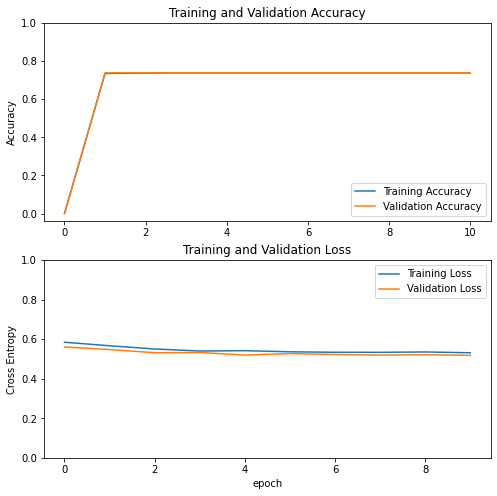

In [30]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
class_names

{'Covid': 0, 'Normal': 1}

<font color='blue'>

## 5. Confusion Matrix

In [24]:
loss, accuracy = model.evaluate(validation_set)
print('Validation accuracy :', accuracy)

87/87 [==============================] - 301s 3s/step - loss: 0.5180 - accuracy: 0.7382
Validation accuracy : 0.7382331490516663


In [25]:
# predict classes of validation dataset
val_predict = model.predict(validation_set)

In [26]:
predict_class = np.argmax(val_predict, axis=1)
predict_class = predict_class.tolist()

In [27]:
from sklearn.metrics import precision_score, recall_score,accuracy_score, f1_score

Accuracy: 0.7382331643736423
F1 score: 0.4247031868360758
Recall: 0.5
Precision: 0.36911658218682114

 clasification report:
               precision    recall  f1-score   support

       Covid       0.00      0.00      0.00       723
      Normal       0.74      1.00      0.85      2039

    accuracy                           0.74      2762
   macro avg       0.37      0.50      0.42      2762
weighted avg       0.54      0.74      0.63      2762



C:\Users\bhart\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bhart\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bhart\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bhart\Anaconda\lib\site-packages\sklearn\metrics\_classificati

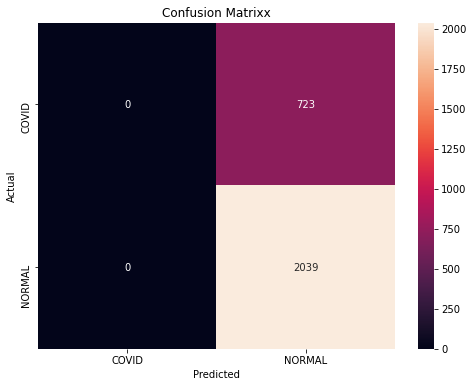

In [28]:
print ('Accuracy:', accuracy_score(validation_set.classes, predict_class))
print ('F1 score:', f1_score(validation_set.classes, predict_class, average='macro'))
print ('Recall:', recall_score(validation_set.classes, predict_class, average='macro'))
print ('Precision:', precision_score(validation_set.classes, predict_class, average='macro'))

labels = ['Covid', 'Normal',]
report = classification_report(validation_set.classes, predict_class, target_names=labels)
print('\n clasification report:\n', report)

cm = confusion_matrix(validation_set.classes, predict_class)
cm_df = pd.DataFrame(cm,
                     index = ['COVID','NORMAL'], 
                     columns = ['COVID','NORMAL'])

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title("Confusion Matrixx")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 5.1 AUC & ROC Curve

In [32]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(validation_set.classes, predict_class)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

Text(0.5, 0, 'False Positive Rate')

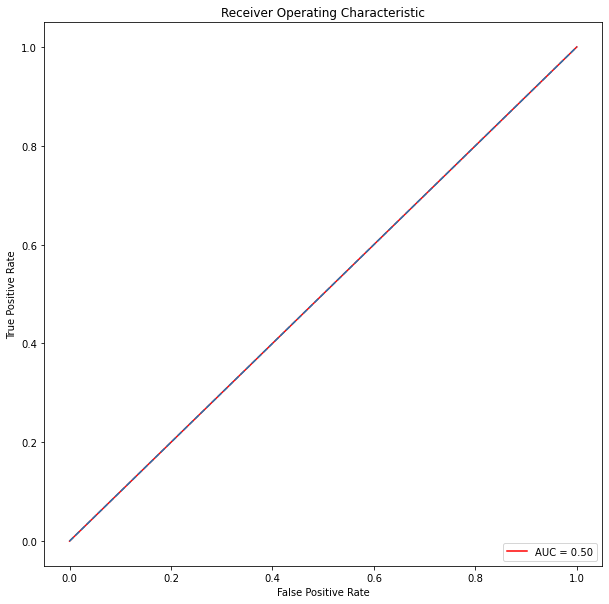

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [29]:
import tensorflow as tf

from keras.models import load_model

model.save('COVID-19 ResNet50 without Fine Tuning.h5')

C:\Users\bhart\Anaconda\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Extra 

In [ ]:
# model2.evaluate(train_dataset)

In [ ]:
# model2.evaluate(validation_dataset)

## Done! 

<font color='DarkViolet'>

**Important Points**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)